In [20]:
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA, KernelPCA

import torch
from torch.utils.data import DataLoader

from src.models import TopologicallyRegularizedAutoencoder
from src.datasets.manifolds import SwissRoll
from src.datasets.splitting import split_dataset

torch.manual_seed(42)
np.random.seed(42)
# Requirements:
# 1. Dataset
# 2. Model (module)
# 3. Model State


In [52]:
# LOAD MODEL:
#method = 'topological'
method = 'vanilla'

if method == 'topological':
    model_path = '../runs/swiss_roll/1/model.pth'
elif method == 'vanilla':
    model_path = '../runs/swiss_roll/2/model.pth'

model = torch.load(model_path)


In [31]:
# LOAD DATASET:
name = 'SwissRoll'
dataset = SwissRoll(train=True)

In [32]:
# SPLIT DATASET:
val_size = 0.2
batch_size = 64

train_loader, validation_loader, test_loader = split_dataset(dataset, val_size, batch_size)

In [53]:
def get_latent_space(model, dataloader):
    #model.load_state_dict(model_state) #used when only model_state is loaded
    
    #ensure that seed is correct (despite several function calls)
    torch.manual_seed(42)
    
    full_latent_space = []
    all_labels = []

    for index, batch in enumerate(dataloader):
        data, label = batch
        latent = model.encode(data)
        reconst = model.decode(latent)
        latent = latent.detach().numpy()        
        reconst = reconst.detach().numpy()

        full_latent_space.append(latent)
        all_labels.append(label)

    full_latent_space = np.concatenate(full_latent_space, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return [full_latent_space, all_labels]

In [55]:
#Choose datasplit:
data_loader = validation_loader #train_loader

In [56]:
if method == 'topological':
    Z_top, labels = get_latent_space(model, data_loader)
    
elif method == 'vanilla':
    Z_van, labels = get_latent_space(model, data_loader)


#vanilla_latent_space, van_labels = get_latent_space(model, vanilla_model_state, dataloader)

In [47]:
#Extract full data space for baseline
full_data_space = []
all_labels = []
torch.manual_seed(42)
for index, batch in enumerate(data_loader):
    data, label = batch
    im = data.detach().numpy() #flatten if its an img
    #im_flat = im.reshape(-1, im.shape[0]).T
    full_data_space.append(im)
    all_labels.append(label)
    #if index == 50:
    #    break
    
full_data_space = np.concatenate(full_data_space, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [57]:
(labels != all_labels).sum() #sanity check that seed works properly! always same samples are used now

0

In [58]:
#check shapes:

Z_van.shape
#full_data_space.shape

(1080, 2)

In [50]:
n_samples = 10000

In [51]:
def plotting(transformed, all_labels, title):
    plt.scatter(transformed[:, 0], transformed[:, 1], c=all_labels, cmap=plt.cm.Spectral)
    plt.title(title)

def plott_all(X,labels, *kwargs):
    fig = plt.figure(1)
    ax = fig.add_subplot(221, projection="3d")
    
    #Plot Swiss Roll Data:
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap=plt.cm.Spectral)

    plt.xticks([]), plt.yticks([])
    myfontsize = 18
    plt.title('Swiss roll', fontsize=myfontsize)
    ax.set_xlabel('x', fontsize=myfontsize)
    ax.set_ylabel('y', fontsize=myfontsize)
    ax.set_zlabel('z', fontsize=myfontsize)
    fig.set_size_inches(12, 12)
    ax.view_init(5, 280) # rotation of the 3D plot
    plt.show()
    
    #add subplots for latent spaces:
    ax = fig.add_subplot(222)
    plotting(kwargs[0], labels, f'2D Latent Space Topological AE')
    ax = fig.add_subplot(223)
    plotting(kwargs[1], labels, f'2D Latent Space Vanilla AE')
    
    

<IPython.core.display.Javascript object>


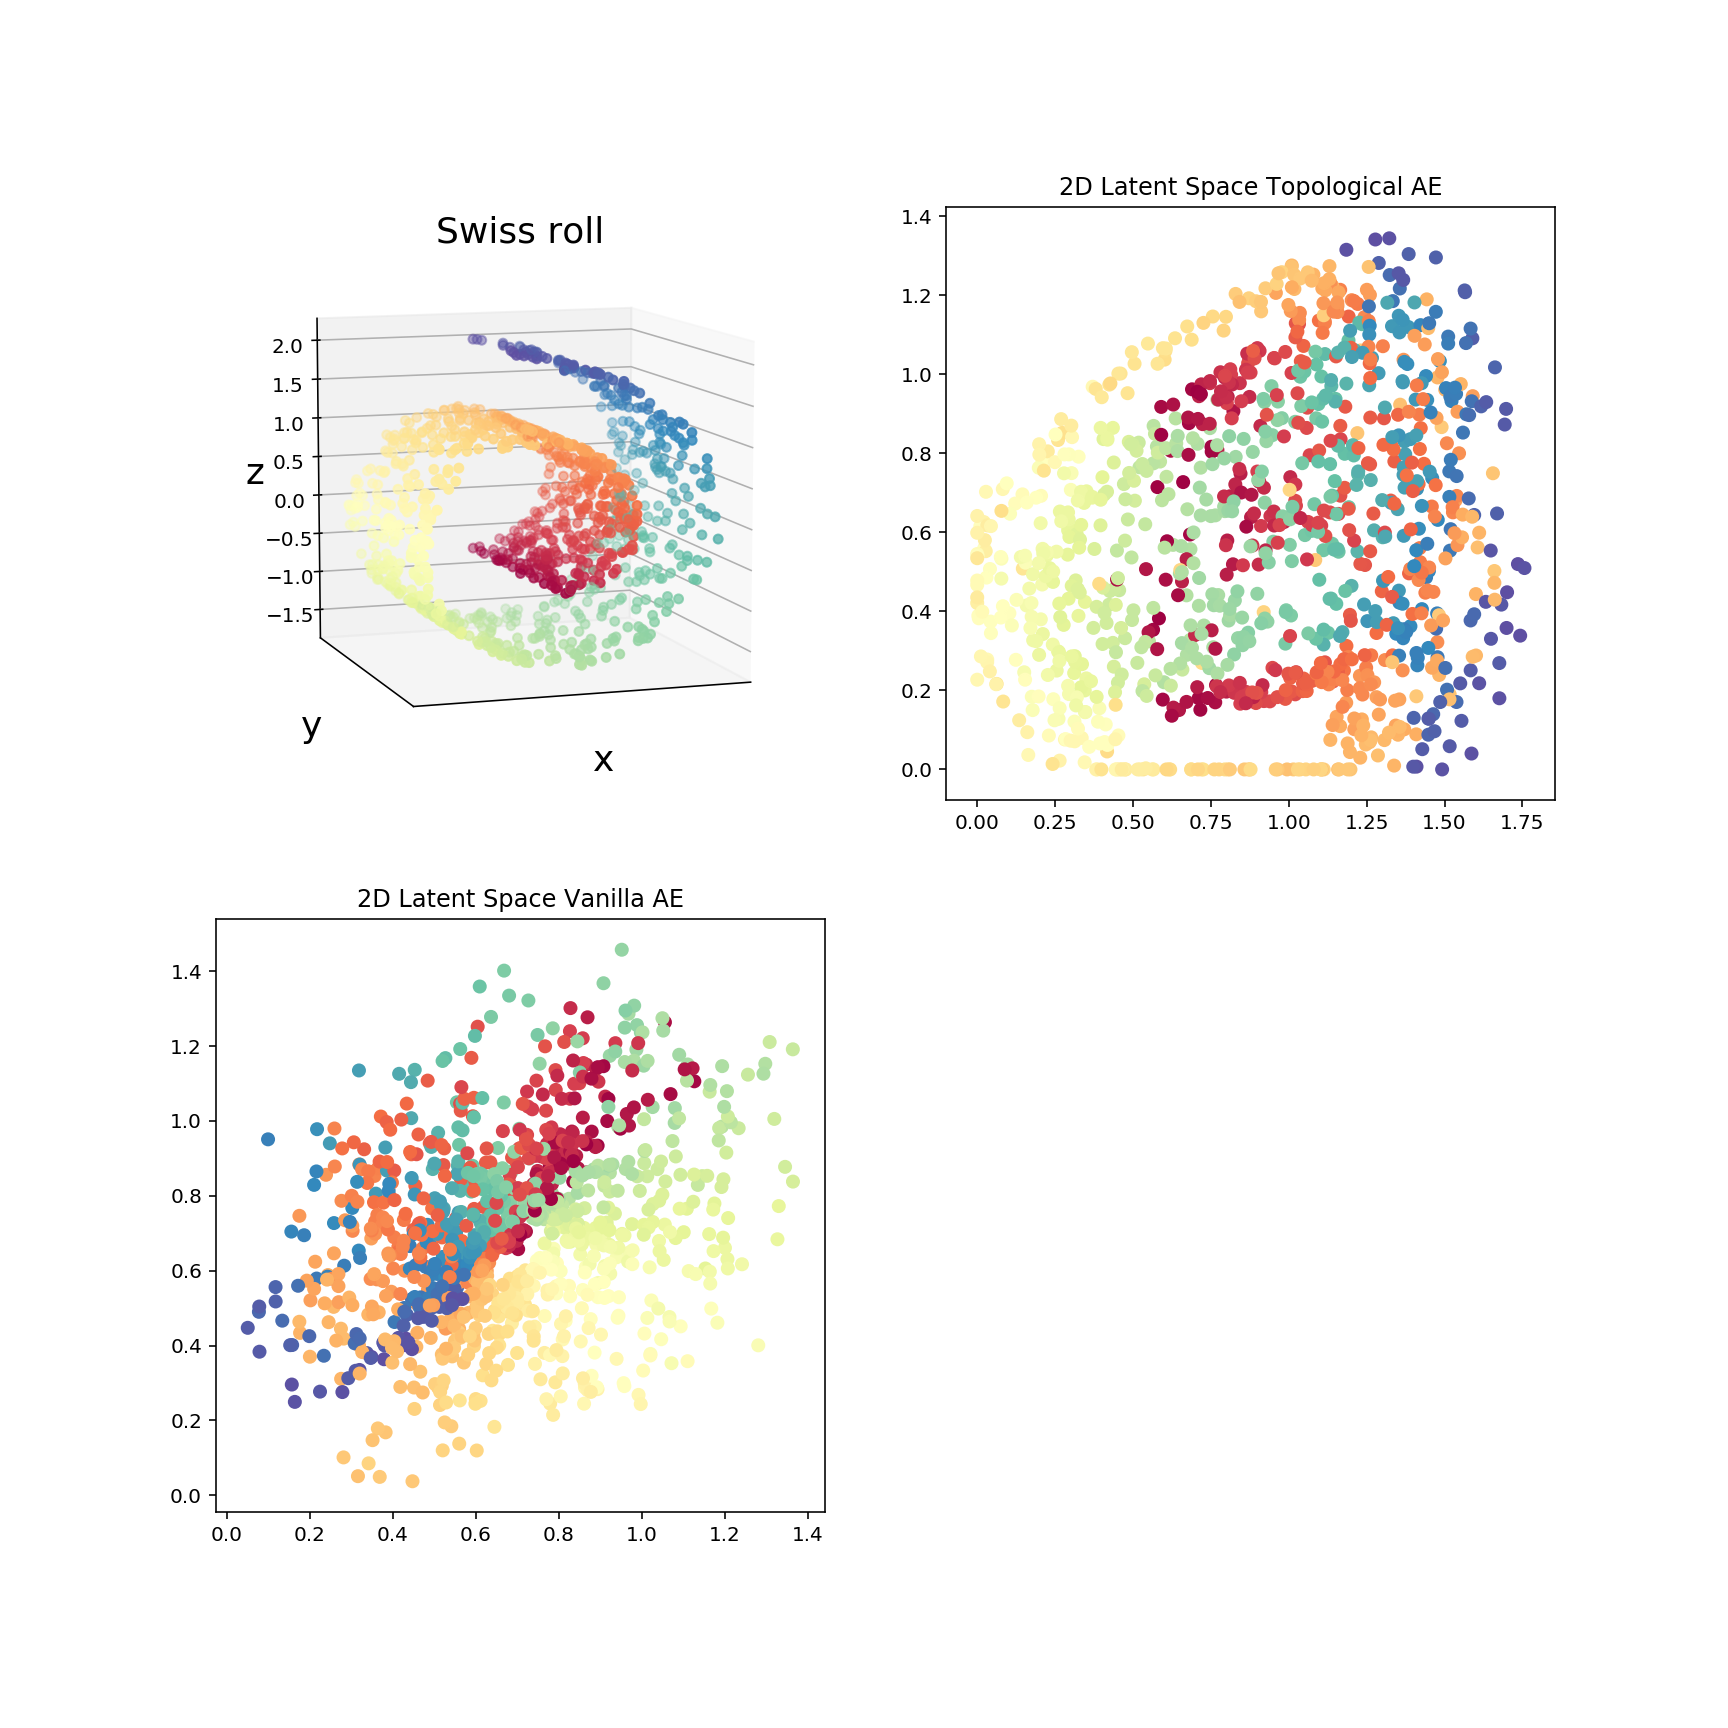

In [59]:
%matplotlib notebook
X = full_data_space[:n_samples,:] # original data
labels = all_labels[:n_samples]
Z_top_n = Z_top[:n_samples,:] # selected latent space samples Top AE
Z_van_n = Z_van[:n_samples,:] # selected latent space samples Vanilla AE

plott_all(X, labels, Z_top_n, Z_van_n)